In [16]:
%matplotlib notebook
import numpy as np

# digit dataset
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# measure time execution
import time

# scikit-learn classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# look for best hyperparamters by cross validation
from sklearn import grid_search

# compute performances classifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

# split data into training and test
from sklearn.cross_validation import train_test_split

np.random.seed(seed=0)

# Import data

In [17]:
#Load labelled digit data
digits = load_digits()
X, y = digits.data, digits.target

# Bench classifiers

In [72]:
# define a fonction that takes estimator as argument and outputs time execution and test score
def bench(name,clf,Xtrain,ytrain,Xtest,ytest):
    # train
    t0 = time.time()
    clf.fit(Xtrain,ytrain)
    time_train = time.time()-t0
    # test
    t0 = time.time()
    ypred = clf.predict(Xtest)
    time_test = time.time()-t0
    # score
    score = accuracy_score(ytest, ypred)
    F1score = f1_score(ytest,ypred,average='macro')
    cf_matrix = confusion_matrix(ytest, ypred)*1.0/np.bincount(ytest)[:,np.newaxis]
    return name,score,F1score,time_train,time_test,cf_matrix,

# find best k for knn using grid_search
clf_knn_grid = grid_search.GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [2,3,4,5,6,7,8,9,10] },cv=6)
clf_knn_grid.fit(X,y)

k_scores = [x[1] for x in clf_knn_grid.grid_scores_]
print "*** knn cross-validation scores for different k : "
print k_scores
k_best = clf_knn_grid.best_params_['n_neighbors']
print "*** knn cross-validation best score for k = ",k_best,' ( score=',clf_knn_grid.best_score_,')'

# launch bench() on various estimators for 21% test data
clf_list = dict()
clf_list['LDA               '] = LinearDiscriminantAnalysis()
clf_list['LogisticRegression'] = LogisticRegression()
clf_list['QDA               '] = QuadraticDiscriminantAnalysis()
clf_list['KNN               '] = KNeighborsClassifier()
clf_list['KNN best          '] = clf_knn_grid.best_estimator_
clf_list['SVM               '] = SVC(gamma=0.001,C=10.0)
results = []

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.21, random_state=0)

results = []
for name in clf_list:
    clf = clf_list[name]
    print "*** currently processing ",name,"..."
    results.append(bench(name,clf,Xtrain,ytrain,Xtest,ytest))


*** knn cross-validation scores for different k : 
[0.96828046744574292, 0.96883695047301055, 0.96939343350027829, 0.96883695047301055, 0.96549805230940455, 0.96549805230940455, 0.96160267111853093, 0.96271563717306619, 0.96048970506399556]
*** knn cross-validation best score for k =  4  ( score= 0.9693934335 )
*** currently processing  LogisticRegression ...
*** currently processing  KNN best           ...
*** currently processing  SVM                ...
*** currently processing  KNN                ...
*** currently processing  LDA                ...
*** currently processing  QDA                ...


In [73]:
# display results
print "*"*80
print "* classifier          * score     * f1 score  * train time (s) * test time (s) *"
print "*"*80
for r in results:
    print "*"*80
    print "*",r[0]," * %0.5f   * %0.5f   * %0.5f        * %0.5f       *" % (r[1],r[2],r[3],r[4])
print "*"*80


********************************************************************************
* classifier          * score     * f1 score  * train time (s) * test time (s) *
********************************************************************************
********************************************************************************
* LogisticRegression  * 0.94974   * 0.95074   * 0.17354        * 0.00022       *
********************************************************************************
* KNN best            * 0.97619   * 0.97668   * 0.00251        * 0.06051       *
********************************************************************************
* SVM                 * 0.99206   * 0.99262   * 0.11309        * 0.02721       *
********************************************************************************
* KNN                 * 0.97619   * 0.97641   * 0.00297        * 0.06680       *
********************************************************************************
* LDA                 * 0.95

- Le **KNN** a le temps de training le plus court, ce qui n'est pas etonnant car ce classifieur n'a aucun calcul de paramètres à réaliser. En revanche, il a le temps de test le plus long car il calcule un grand nombre de distance (Ntrain) qu'il doit en plus partiellement mettre dans l'ordre pour selectionner la plus petite.
- Le temps de training du **LDA** est plus court que celui du **QDA**, car le LDA inverse une seule matrice (celle de variance-covariance supposé commune à toutes les classes) alors que le QDA inverse 10 matrices (celles propre à chaque classe) 
- La **Regression Logistique** a le temps de training le plus long car face à un probleme multi classe, scikit fait une descente de gradient par la methode de Newton (*'newton-cg'*) ou de quasi-Newton (*'lbfgs'*) où il faut approximer un Hessien (très couteux) à chaque itération. En revanche, ce classifieur a un temps de test court car il s'agit d'une simple convolution suivi d'un logit.
- Le meilleur résultat de classification est obtenu pour la **SVM** avec un noyau non lineaire gaussien (gamma de 0.001). En effet, la technique du kernel trick permet de tracer des frontières plus complexes que les frontières linéaires (LDA) ou quadratiques (QDA), avec un minimm d'overfitting car les frontières sont de vastes marges (on s'est tout de même autorisé un slackness C de 10.0)

# Confusion matrix

In [74]:
scores = np.asarray([r[1] for r in results])
ind_min = scores.argmin()
ind_max = scores.argmax()
np.set_printoptions(precision=3)
print "\n*** confusion matrix for worst score (",results[ind_min][0],",%0.5f) : \n" % results[ind_min][1]
print results[ind_min][5]
print "\n*** confusion matrix for best score (",results[ind_max][0],",%0.5f) : \n" % results[ind_max][1]
print results[ind_max][5]


*** confusion matrix for worst score ( QDA                ,0.88624) : 

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.886  0.029  0.     0.     0.     0.     0.     0.086  0.   ]
 [ 0.     0.108  0.757  0.     0.     0.     0.     0.     0.135  0.   ]
 [ 0.     0.     0.     0.812  0.     0.     0.     0.     0.188  0.   ]
 [ 0.     0.03   0.     0.     0.727  0.     0.     0.242  0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.     0.     0.   ]
 [ 0.     0.     0.     0.025  0.     0.     0.     0.975  0.     0.   ]
 [ 0.     0.024  0.024  0.     0.     0.     0.     0.024  0.929  0.   ]
 [ 0.     0.     0.     0.     0.     0.048  0.     0.095  0.119  0.738]]

*** confusion matrix for best score ( SVM                ,0.99206) : 

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.    

Le mauvais classifieur se trompe majoritairement sur le chiffre "2", qu'il confond avec un "1" :

<IPython.core.display.Javascript object>


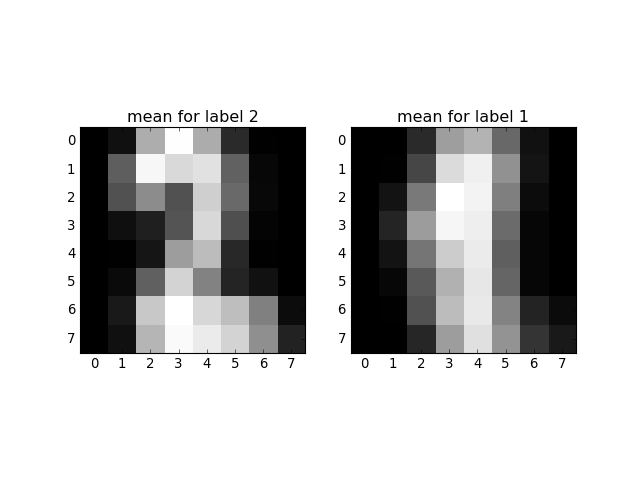

In [75]:
fig = plt.figure()
for i,l in enumerate((2,1)):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(np.reshape(np.mean(X[y==l,:],axis=0),(8,8)), cmap=plt.cm.gray, interpolation='nearest')
    ax.set_title("mean for label "+str(l))

# Graphes

Error Unable to plot bivariate distribution


<IPython.core.display.Javascript object>


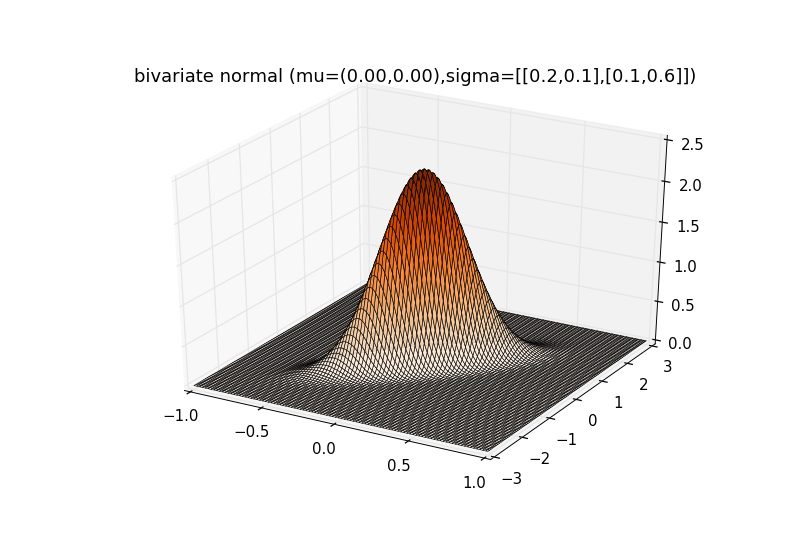

In [103]:
from mpl_toolkits.mplot3d import Axes3D

def plot_bivariate(sigma,mu):
    if(sigma[0,1] != sigma[1,0]):
        print "Error : Variance-Covariance matrix should be symmetric"
        return 0
    if(np.abs(np.linalg.det(sigma))<1e-8):
        print "Error : Variance-Covariance matrix should be inversible"
        return 0
    step = 300
    xx = np.linspace(mu[0]-5*sigma[0,0], mu[0]+5*sigma[0,0], step)
    yy = np.linspace(mu[1]-5*sigma[1,1], mu[1]+5*sigma[1,1], step)
    Xg, Yg = np.meshgrid(xx, yy)
    Z = plt.mlab.bivariate_normal(Xg, Yg, sigmax=sigma[0,0],
                                sigmay=sigma[1,1],
                                mux=mu[0], muy=mu[1],
                                sigmaxy=sigma[1,0])
    if(np.isnan(Z).any()):
        print "Error Unable to plot bivariate distribution"
        return 0
    fig2 = plt.figure(figsize=(9, 6), dpi = 90)
    ax = fig2.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, Z, cmap='Oranges',rstride=3, cstride=3, alpha=0.9, linewidth=0.5)
    plt.title("bivariate normal (mu=(%.2f,%.2f),sigma=[[%.1f,%.1f],[%.1f,%.1f]])" % (mu[0],mu[1],sigma[0,0],sigma[0,1],sigma[1,0],sigma[1,1]))
    
    return plt

mu = np.asarray([0,0])
sigma1 = np.asarray([[0.2,0.1],[0.1,0.2]])
sigma2 = np.asarray([[0.2,0.1],[0.1,0.6]])
if(plot_bivariate(sigma1,mu) != 0):
    plt.show()
if(plot_bivariate(sigma2,mu) != 0):
    plt.show()


    